Pair trading 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf              # Importation for using Yahoo finance
import datetime
import pandas as pd
import seaborn as sns
import csv
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from IPython.display import clear_output
import statsmodels.api as sm

In [8]:
chemin_f1_csv= r"/Users/victor/Desktop/ws/Pair_trading/SNPS.xls"
df= pd.read_excel(chemin_f1_csv)
print(df.head)

<bound method NDFrame.head of            Date  Dernier    Ouv.   Plus Haut  Plus Bas     Vol.  Variation %
0    2024-08-09   515.61  512.28      523.08    512.28  279,89K       0.0011
1    2024-08-08   515.03  504.40      518.13    493.71    1,11M       0.0511
2    2024-08-07   489.97  513.20      520.98    488.45    1,90M      -0.0189
3    2024-08-06   499.39  500.00      510.55    487.87    1,49M       0.0237
4    2024-08-05   487.84  475.00      495.00    474.57    2,05M      -0.0355
...         ...      ...     ...         ...       ...      ...          ...
1154 2020-01-08   145.86  143.20      146.60    142.56    1,24M       0.0203
1155 2020-01-07   142.96  141.18      143.48    140.32  701,22K       0.0069
1156 2020-01-06   141.98  140.52      142.16    139.70  924,83K       0.0016
1157 2020-01-03   141.76  141.10      142.09    140.05  834,76K      -0.0078
1158 2020-01-02   142.87  140.31      142.93    139.84    1,10M       0.0264

[1159 rows x 7 columns]>


In [9]:
# File imports 

chemin_f1_csv= r"/Users/victor/Desktop/ws/Pair_trading/SNPS.xls"
df= pd.read_excel(chemin_f1_csv)
df= df[["Date","Dernier"]]

chemin_f2_csv= r"/Users/victor/Desktop/ws/Pair_trading/CDNS .xls"
df2 = pd.read_excel(chemin_f2_csv)
df2 = df2[["Date","Dernier"]]
df = pd.merge(df, df2, on="Date", how="outer")
df = df.rename(columns={"Dernier_x": "Cours SNPS"})
df = df.rename(columns={"Dernier_y": "Cours CDNS"})

print(df)

           Date  Cours SNPS  Cours CDNS
0    2024-08-09      515.61      266.48
1    2024-08-08      515.03      268.68
2    2024-08-07      489.97      250.31
3    2024-08-06      499.39      259.80
4    2024-08-05      487.84      246.84
...         ...         ...         ...
1154 2020-01-08      145.86       72.28
1155 2020-01-07      142.96       71.07
1156 2020-01-06      141.98       70.85
1157 2020-01-03      141.76       70.42
1158 2020-01-02      142.87       71.44

[1159 rows x 3 columns]


In [12]:
print(df['Cours SNPS'].dtype)
print(df['Cours CDNS'].dtype)

float64
float64


In [15]:

df['Cours SNPS'] = df['Cours SNPS'].astype(float)
df['Cours CDNS'] = df['Cours CDNS'].astype(float)


df['Date'] = pd.to_datetime(df['Date'], format ="%d/%m/%Y")
df = df.sort_values(by='Date')

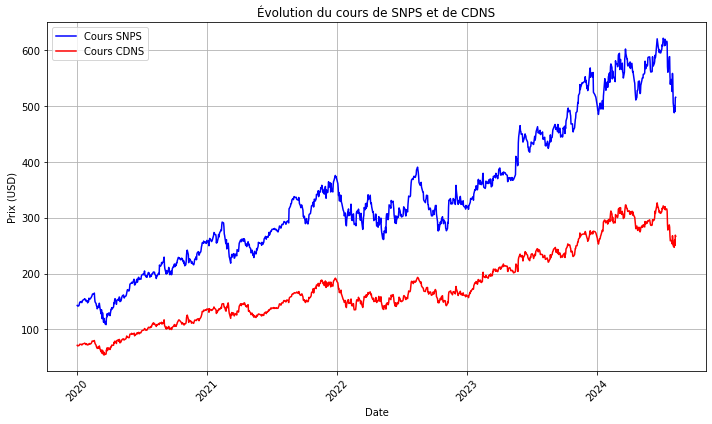

In [16]:
# plot the two stocks behavior over 20 to 24
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Cours SNPS'], color='blue', label='Cours SNPS')
plt.plot(df['Date'], df['Cours CDNS'], color='red', label='Cours CDNS')
plt.title('Évolution du cours de SNPS et de CDNS')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
arrayDate=np.array(df['Date'])
arrayDate=arrayDate[1:]

In [19]:
arraySNPS = np.array(df['Cours SNPS'])
arraySNPS=arraySNPS[1:]
arrayCDNS = np.array(df['Cours CDNS'])
arrayCDNS=arrayCDNS[1:]


# Apply a logarithm on the values 
Y = np.log(arraySNPS)
X = np.log(arrayCDNS)



# Add a constant to X for the OLS
X = sm.add_constant(X)


# create the OLS model 
model = sm.OLS(Y, X)

# adjust  the model to the data
results = model.fit()

# show the parameters estimated 
print(results.params)

# Adjust X dimension for a match with Y dimension 
X_adjusted = X[:, 1]  # Select only the second column of X


# Compute the mistakes
alpha = results.params[0]
beta = results.params[1]

errors = Y - (alpha + X_adjusted* beta)

[0.84013322 0.96571413]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


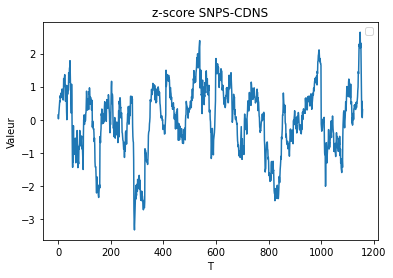

In [20]:
spread = errors
zscore = (spread - np.mean(spread)) / np.std(spread)
plt.plot(zscore)
plt.title("z-score SNPS-CDNS")
plt.xlabel("T")
plt.ylabel("Valeur")
plt.legend()
plt.show()

In [31]:
for i in range(1, len(arraySNPS)+1):
    strat.loc[i,'Date'] = arrayDate[i-1]
    strat.loc[i, 'SNPS'] = arraySNPS[i-1]
    strat.loc[i, 'CDNS'] = arrayCDNS[i-1]
    strat.loc[i, 'z-score'] = zscore[i-1]

    strat.loc[i,'short enter'] = (strat.loc[i,'z-score'] > signal_entree_short) & (~strat.loc[i-1,'is short'])
    strat.loc[i, "short exit"] = (strat.loc[i,'z-score'] < signal_sortie_short) & (strat.loc[i-1, 'is short'])
    strat.loc[i,'is short'] = strat.loc[i,'short enter'] | (strat.loc[i-1,"is short"] & ~strat.loc[i,"short exit"])

    strat.loc[i,'long enter'] = (strat.loc[i,'z-score'] > signal_entree_long) & (~strat.loc[i-1,'is long'])
    strat.loc[i, "long exit"] = (strat.loc[i,'z-score'] < signal_sortie_long) & (strat.loc[i-1, 'is long'])
    strat.loc[i,'is long'] = strat.loc[i,'long enter'] | (strat.loc[i-1,"is long"] & ~strat.loc[i,"long exit"])

    if strat.loc[i,'is short'] | strat.loc[i,"short exit"]:
        strat.loc[i,"gain SNPS"] = strat.loc[i-1,"SNPS"] - strat.loc[i,"SNPS"]
        strat.loc[i,"gain CDNS"] = strat.loc[i,"CDNS"] - strat.loc[i-1,"CDNS"]
        strat.loc[i,"gain total"] = strat.loc[i,"gain SNPS"] + strat.loc[i,"gain CDNS"]

        if strat.loc[i-1,"SNPS"] != 0:
            strat.loc[i,"rendement SNPS"] = strat.loc[i,"gain SNPS"] / strat.loc[i-1,"SNPS"]
        else:
            strat.loc[i,"rendement SNPS"] = 0  # ou gérer différemment

        if strat.loc[i-1,"CDNS"] != 0:
            strat.loc[i,"rendement CDNS"] = strat.loc[i,"gain CDNS"] / strat.loc[i-1,"CDNS"]
        else:
            strat.loc[i,"rendement CDNS"] = 0  # ou gérer différemment

        strat.loc[i,"rendement total"] = (strat.loc[i,"rendement SNPS"] + strat.loc[i,"rendement CDNS"]) / 2

    elif strat.loc[i,'is long'] | strat.loc[i,"long exit"]:
        strat.loc[i,"gain SNPS"] = strat.loc[i,"SNPS"] - strat.loc[i-1,"SNPS"]
        strat.loc[i,"gain CDNS"] = strat.loc[i-1,"CDNS"] - strat.loc[i,"CDNS"]
        strat.loc[i,"gain total"] = strat.loc[i,"gain SNPS"] + strat.loc[i,"gain CDNS"]

        if strat.loc[i-1,"SNPS"] != 0:
            strat.loc[i,"rendement SNPS"] = strat.loc[i,"gain SNPS"] / strat.loc[i-1,"SNPS"]
        else:
            strat.loc[i,"rendement SNPS"] = 0  # ou gérer différemment

        if strat.loc[i-1,"CDNS"] != 0:
            strat.loc[i,"rendement CDNS"] = strat.loc[i,"gain CDNS"] / strat.loc[i-1,"CDNS"]
        else:
            strat.loc[i,"rendement CDNS"] = 0  # ou gérer différemment

        strat.loc[i,"rendement total"] = (strat.loc[i,"rendement SNPS"] + strat.loc[i,"rendement CDNS"]) / 2

    else:
        strat.loc[i,"gain SNPS"] = 0
        strat.loc[i,"gain CDNS"] = 0
        strat.loc[i,"gain total"] = 0
        strat.loc[i,"rendement SNPS"] = 0
        strat.loc[i,"rendement CDNS"] = 0
        strat.loc[i,"rendement total"] = 0


strat.to_excel("strat.xlsx", index=False)

In [32]:
strat['cumulative_returns'] = (strat["rendement total"]+1).cumprod()-1
strat['Date'] = pd.to_datetime(strat['Date'])

In [34]:
import plotly.graph_objs as go

# Create the graph 
fig = go.Figure()


# Add the componded interest series 

fig.add_trace(go.Scatter(x=strat['Date'], y=strat['cumulative_returns'], mode='lines', name='Rendements composés', line=dict(color='blue', width=2)))


# Formating title and axis legend 
fig.update_layout(title='Rendements composés dans le temps',
                   xaxis_title='Date',
                   yaxis_title='Rendements composés')

# Show the graph
fig.show()

In [35]:
df_2020 = strat[strat['Date'].dt.year == 2020]
df_2021 = strat[strat['Date'].dt.year == 2021]
df_2022 = strat[strat['Date'].dt.year == 2022]
df_2023 = strat[strat['Date'].dt.year == 2023]
df_2024 = strat[strat['Date'].dt.year == 2024]

In [36]:
def ann_return(returns):
  mu=np.mean(returns)
  ann_return=(1+mu)**(len(returns))-1
  return ann_return

In [37]:
def Compute_Vol(returns):
    mu = np.mean(returns)  # Compute the mean
    sigma_daily = np.sqrt(np.sum((returns - mu)**2) / (len(returns) - 1))  # Dayli SD
    sigma = np.sqrt(len(returns)) * sigma_daily  # Multiple to annualize 
    return sigma

In [38]:
def sharpe_ratio(returns,rf=0):
  ret=ann_return(returns)
  vol=Compute_Vol(returns)
  return (ret-rf)/vol

In [39]:
def max_drawdown(returns):
    valeurs_cumulees = (1 + returns).cumprod()  # Calcul des valeurs cumulées 
    max_cumule = valeurs_cumulees.cummax()  # Maximum cumulé jusqu'à cette période
    drawdown = (valeurs_cumulees / max_cumule) - 1  # Drawdown pour chaque période
    max_drawdown = drawdown.min()  # Drawdown maximum

    return max_drawdown
     

In [40]:
results = pd.DataFrame(columns=['Year','Ann return','Volatility','Sharpe Ratio','Max Drawdown'])

In [41]:
#With a RF rate of 0 in 20

ann_return_2020 = ann_return(df_2020['rendement total'])
volatility_2020 = Compute_Vol(df_2020['rendement total'])
sharpe_ratio_2020 = sharpe_ratio(df_2020['rendement total'])
max_drawdown_2020 = max_drawdown(df_2020['rendement total'])
results.loc[1] = ["2020", ann_return_2020, volatility_2020, sharpe_ratio_2020, max_drawdown_2020]

In [42]:
#Still 0 in 21
ann_return_2021 = ann_return(df_2021['rendement total'])
volatility_2021 = Compute_Vol(df_2021['rendement total'])
sharpe_ratio_2021 = sharpe_ratio(df_2021['rendement total'])
max_drawdown_2021 = max_drawdown(df_2021['rendement total'])

results.loc[2] = ["2021", ann_return_2021, volatility_2021, sharpe_ratio_2021, max_drawdown_2021]

In [43]:
ann_return_2022 = ann_return(df_2022['rendement total'])
volatility_2022 = Compute_Vol(df_2022['rendement total'])
sharpe_ratio_2022 = sharpe_ratio(df_2022['rendement total'])
max_drawdown_2022 =max_drawdown(df_2022['rendement total'])

results.loc[3] = ["2022", ann_return_2022, volatility_2022, sharpe_ratio_2022, max_drawdown_2022]

In [44]:
ann_return_2023 = ann_return(df_2023['rendement total'])
volatility_2023 = Compute_Vol(df_2023['rendement total'])
sharpe_ratio_2023 = sharpe_ratio(df_2023['rendement total'],0.025)
max_drawdown_2023 = max_drawdown(df_2023['rendement total'])

results.loc[4] = ["2023", ann_return_2023, volatility_2023, sharpe_ratio_2023, max_drawdown_2023]

In [45]:
ann_return_2024 = ann_return(df_2024['rendement total'])
volatility_2024 = Compute_Vol(df_2024['rendement total'])
sharpe_ratio_2024 = sharpe_ratio(df_2024['rendement total'],0.025)
max_drawdown_2024 = max_drawdown(df_2024['rendement total'])

results.loc[5] = ["2024", ann_return_2024, volatility_2024, sharpe_ratio_2024, max_drawdown_2024]

In [46]:
results.head()
results.to_excel("results.xlsx", index=False)